# CNN-TDA Net Tutorial: Transient-vs-Bogus Classification
In this tutorial, we will introduce how to use `cnntdanet` package to solve transient-vs-bogus classification. We note that our package are not released yet and we are still building and documenting. We will release our package as soon as possible.

## 1. Setting

In [1]:
import sys
sys.path.append('../')

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

We provide `seed_all` utility function that can control randomness throughout this program, allowing us to obtain the same results whenever we run the code. This step requires `TensorFlow > 2.8.0` for `tf.config.experimental.enable_op_determinism()`.

In [2]:
from cnntdanet.utils import seed_all

seed = 0
seed_all(seed)

## 2. Loading Transient-vs-Bogus dataset
The IMSNG team at Seoul National University provides us with 3,731 images, 307 of which are transients and the rest are bogus.

In [3]:
from cnntdanet.utils import load_data, get_img

dir_data = '../datasets/20220209_LOAO_check'
df = load_data(dir_data)

X = get_img(df)
y = df['Label'].to_numpy(dtype=np.int64)

print("The shape of X: ", X.shape)
print(f"The number of transients   : {y.sum():>4} images ({100 * y.sum() / len(X):.2f}%)")
print(f"The number of bogus samples: {len(X) - y.sum()} images ({100 * (len(X) - y.sum()) / len(X):.2f}%)")

The shape of X:  (3716, 38, 38, 1)
The number of transients   :  351 images (9.45%)
The number of bogus samples: 3365 images (90.55%)


`cnntdanet` has many utility functions for visualization, so you can quickly explore and analyze data. The following codes visualizes 16 data that are chosen at random.

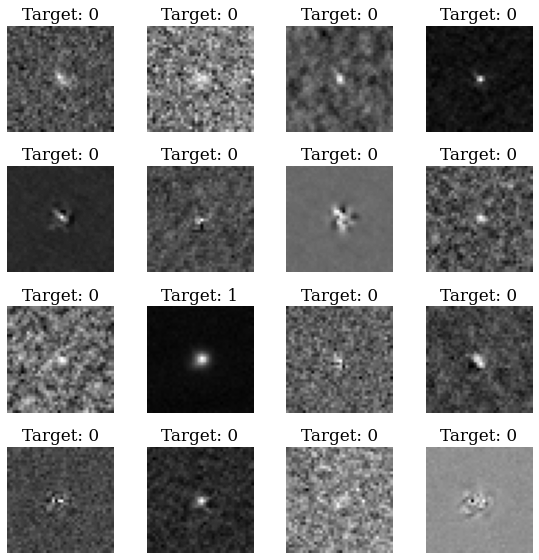

In [4]:
from cnntdanet.utils.plotting import visualize_image_samples

# The number of random samples
N = 16

# Choose random indices
sample_indices = np.random.choice(a=range(len(X)), size=16)

# Take samples
samples = X[sample_indices]
target = y[sample_indices]

visualize_image_samples(samples, y[sample_indices], scale=2)

## 3. Create topological features
`cnntdanet` use `giotto-tda` to create topological features. We predefined some of `gtda.pipeline.Pipeline`s for persistence image, persistence landscape, and betti-curve, which allow you to easily create topological features even though you are not familar with TDA.

<br>

(Optional) If you are familar with `giotto-tda`, of course, you can use your own tda pipeline by using `gtda.pipeline.Pipeline`.

In [5]:
from cnntdanet.tda import get_tda_pipeline

# The method name should be one of ['persistence-image', 'persistence-landscape', 'betti-curve']
method = 'persistence-landscape'

# For each method, you should define some required arguments.
n_bins = 100
n_layers=1

# Build a gtda.pipeline.Pipeline
pipeline = get_tda_pipeline(method=method, n_bins=n_bins, n_layers=n_layers)

##########
# or You can define your own pipeline
# pipeline = Pipeline([('diagram', CubicalPersistence(homology_dimensions=[0, 1], n_jobs=-1)),
#                      ('Scaler', Scaler(n_jobs=-1)),
#                      ('Vectorization', BettiCurve(n_jobs=-1)),
#                      ('Reshape', ChannelLast())])
#########

print(pipeline)

Pipeline(steps=[('Diagram',
                 CubicalPersistence(homology_dimensions=[0, 1], n_jobs=-1)),
                ('Scaler', Scaler(n_jobs=-1)),
                ('Vectorization', PersistenceLandscape(n_jobs=-1)),
                ('Reshape', ChannelLast())])


One can obtain topological features by feeding our data into `pipeline.fit_transform`

In [6]:
X_tda = pipeline.fit_transform(X)
X_tda = X_tda.astype(np.float32)

print(X_tda.shape)

(3716, 100, 2)


Let's visualize a sample with a topological vector

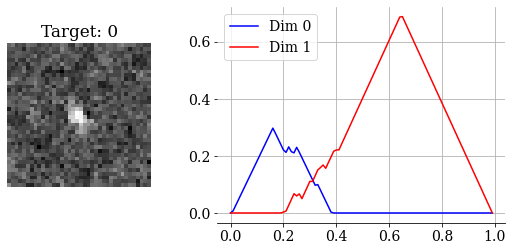

In [7]:
# The number of random samples
N = 1

# Choose random indices
sample_indices = np.random.choice(a=range(len(X)), size=N)

# Take samples
img = X[sample_indices]
tda = X_tda[sample_indices]
label = y[sample_indices]

# Visualization
fig= plt.figure(figsize=(8, 5))

ax_img = fig.add_axes([0.01, 0.3, 0.4, 0.4])
ax_img.imshow(img[0], cmap='gray'); ax_img.axis('off'); ax_img.set_title(f"Target: {label[0]}")

ax_tda = fig.add_axes([0.45, 0.2, 0.5, 0.6])
filts = np.arange(len(tda[0])) / len(tda[0])
ax_tda.plot(filts, tda[0, :, 0], 'b-', label="Dim 0")
ax_tda.plot(filts, tda[0, :, 1], 'r-', label="Dim 1")
ax_tda.grid(); ax_tda.legend();
ax_tda.spines['top'].set_visible(False)
ax_tda.spines['left'].set_visible(False)
ax_tda.spines['right'].set_visible(False)

plt.show(fig)

## 4. Modeling
- Before moving to modeling part, let divide our dataset into a training and a validation dataset.

In [8]:
y_ = y.copy()  # y_ keeps labels before one-hot encoding

In [9]:
from sklearn.model_selection import train_test_split

train_indices, valid_indices = train_test_split(np.arange(len(X)), shuffle=True, stratify=y_, test_size=0.1, random_state=seed)
train_indices = np.sort(train_indices)

# One-hot encoding
n_classes = 2
y = tf.keras.utils.to_categorical(y_, n_classes) 

X_img_train, X_tda_train, y_train = X[train_indices], X_tda[train_indices], y[train_indices]
X_img_valid, X_tda_valid, y_valid = X[valid_indices], X_tda[valid_indices], y[valid_indices]

### 2D CNN
We also provide predefined 1D- and 2D-CNN, which are WaveNet and O'TRAIN, respectively. One can build a O'TRAIN as follows:

In [10]:
from cnntdanet.models import get_cnn_net, get_cnn_tda_net

input_shape = (38, 38, 1) 
n_classes = 2

# Build a single 2D-CNN network
cnn = get_cnn_net(input_shape=input_shape, n_classes=n_classes)

# Define a loss function, an optimization method, and evaluate metrics
cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

# Train the model
history = cnn.fit(
    X_img_train, y_train,
    validation_split=0.1,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)],
    epochs=20
)

Epoch 1/20
95/95 [==============================] - 6s 13ms/step - loss: 0.2478 - acc: 0.9229 - val_loss: 0.2074 - val_acc: 0.9970
Epoch 2/20
95/95 [==============================] - 1s 9ms/step - loss: 0.2042 - acc: 0.9478 - val_loss: 0.0455 - val_acc: 0.9970
Epoch 3/20
95/95 [==============================] - 1s 8ms/step - loss: 0.2060 - acc: 0.9428 - val_loss: 0.0205 - val_acc: 0.9970
Epoch 4/20
95/95 [==============================] - 1s 9ms/step - loss: 0.2048 - acc: 0.9475 - val_loss: 0.0419 - val_acc: 0.9970
Epoch 5/20
95/95 [==============================] - 1s 8ms/step - loss: 0.1793 - acc: 0.9555 - val_loss: 0.0820 - val_acc: 1.0000
Epoch 6/20
95/95 [==============================] - 1s 9ms/step - loss: 0.1701 - acc: 0.9545 - val_loss: 0.0496 - val_acc: 1.0000
Epoch 7/20
95/95 [==============================] - 1s 8ms/step - loss: 0.1446 - acc: 0.9568 - val_loss: 0.0219 - val_acc: 0.9970
Epoch 8/20
95/95 [==============================] - 1s 8ms/step - loss: 0.1463 - acc: 0.9

We also have an utility function for plotting a learning curve.

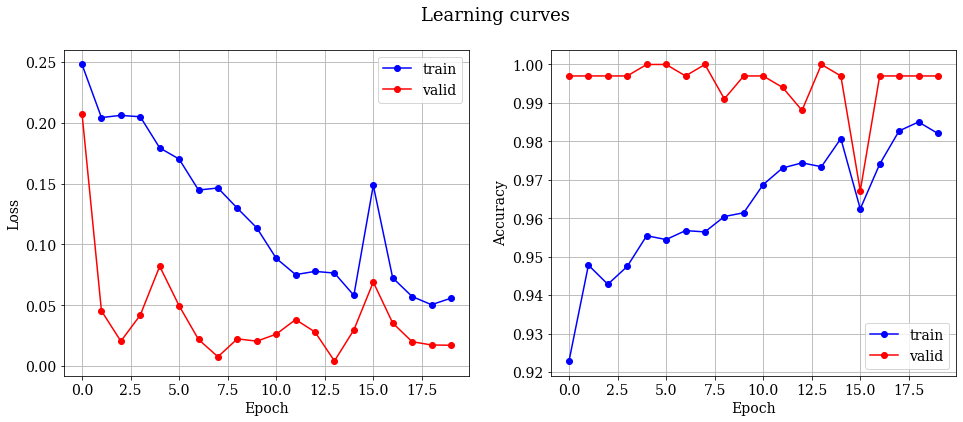

In [11]:
from cnntdanet.utils.plotting import plot_learning_curve

plot_learning_curve(history.history, dir_save=None)

Let evaluate the 2D-CNN on the test data

In [12]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
y_true = np.argmax(y_valid, axis=1) # From one-hot encoding to label
y_pred = cnn.predict(X_img_valid)  # Make predictions
y_pred = np.argmax(y_pred, axis=1)  # Take the maximum probability for each prediction

print(f"Accuracy  : {100 * accuracy_score(y_true, y_pred):.2f}")
print(f"Recall    : {100 * recall_score(y_true, y_pred):.2f}")
print(f"Precision : {100 * precision_score(y_true, y_pred):.2f}")
print(f"F1        : {100 * f1_score(y_true, y_pred):.2f}")

Accuracy  : 98.66
Recall    : 88.57
Precision : 96.88
F1        : 92.54


### CNN-PL Net
CNN-PL Net can be defined and trained as follows

In [13]:
method = 'persistence-landscape'
input_shape = {'img': (38, 38, 1), 'tda': (n_bins, 2)}
n_classes = 2

# Build a single 2D-CNN network
cnn_tda = get_cnn_tda_net(method=method, input_shape=input_shape, n_classes=n_classes)
# Define a loss function, an optimization method, and evaluate metrics
cnn_tda.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
# Train the model
history = cnn_tda.fit(
    [X_img_train, X_tda_train], y_train,
    validation_split=0.1,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)],
    epochs=20
)

Epoch 1/20
95/95 [==============================] - 4s 26ms/step - loss: 0.2396 - acc: 0.9206 - val_loss: 0.1800 - val_acc: 0.9940
Epoch 2/20
95/95 [==============================] - 2s 21ms/step - loss: 0.1883 - acc: 0.9555 - val_loss: 0.0889 - val_acc: 0.9970
Epoch 3/20
95/95 [==============================] - 2s 19ms/step - loss: 0.1838 - acc: 0.9535 - val_loss: 0.0336 - val_acc: 0.9940
Epoch 4/20
95/95 [==============================] - 2s 18ms/step - loss: 0.1872 - acc: 0.9548 - val_loss: 0.0312 - val_acc: 1.0000
Epoch 5/20
95/95 [==============================] - 2s 19ms/step - loss: 0.1796 - acc: 0.9538 - val_loss: 0.1401 - val_acc: 0.9940
Epoch 6/20
95/95 [==============================] - 2s 18ms/step - loss: 0.1940 - acc: 0.9528 - val_loss: 0.0419 - val_acc: 1.0000
Epoch 7/20
95/95 [==============================] - 2s 18ms/step - loss: 0.1834 - acc: 0.9545 - val_loss: 0.0692 - val_acc: 0.9940
Epoch 8/20
95/95 [==============================] - 2s 18ms/step - loss: 0.1810 - a

The learning curve is shown below.

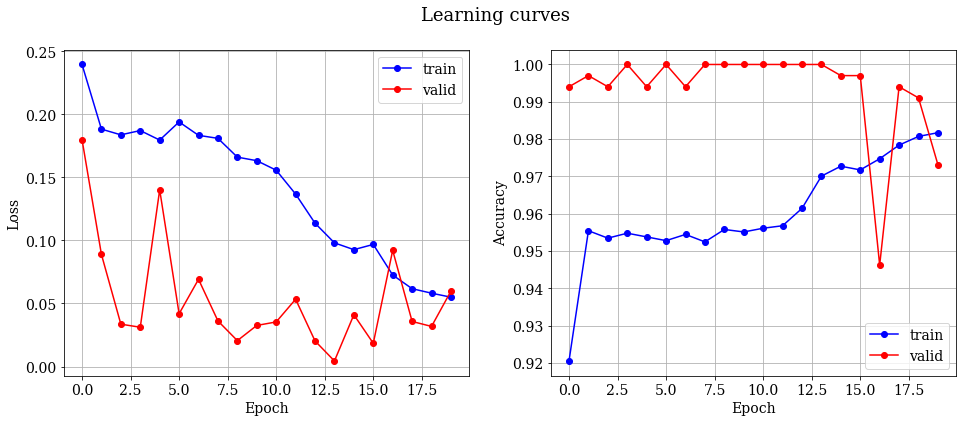

In [14]:
plot_learning_curve(history.history, dir_save=None)

Let evaluate the CNN-PL Net on the test data

In [15]:
y_true = np.argmax(y_valid, axis=1) # From one-hot encoding to label
y_pred = cnn_tda.predict([X_img_valid, X_tda_valid])  # Make predictions
y_pred = np.argmax(y_pred, axis=1)  # Take the maximum probability for each prediction

print(f"Accuracy  : {100 * accuracy_score(y_true, y_pred):.2f}")
print(f"Recall    : {100 * recall_score(y_true, y_pred):.2f}")
print(f"Precision : {100 * precision_score(y_true, y_pred):.2f}")
print(f"F1        : {100 * f1_score(y_true, y_pred):.2f}")

Accuracy  : 98.39
Recall    : 94.29
Precision : 89.19
F1        : 91.67


## 5. Grad-CAM Analysis
We also provide [Grad-CAM](https://arxiv.org/abs/1610.02391) analysis for a CNN and a CNN-TDA Net, which allows you to analyze what features our model extracts.

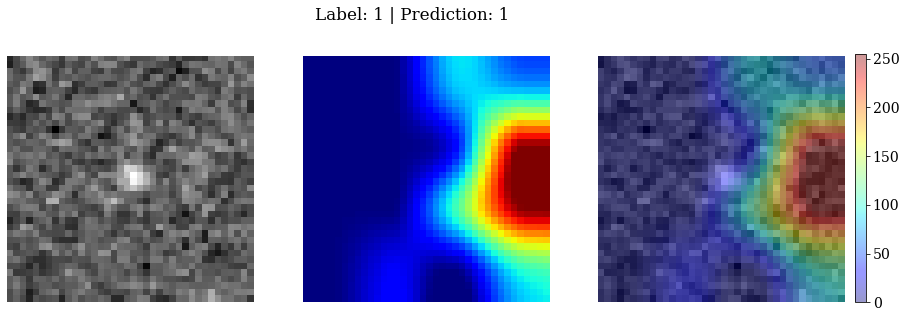

In [16]:
from cnntdanet.gradcam import GradCAMOnCNN

idx = 14
img = X_img_valid[idx:idx+1]
label = np.argmax(y_valid, axis=1)[idx]

gradcam_cnn = GradCAMOnCNN(cnn, layer_name='conv2d_4')
gradcam_cnn.to_heatmap(img, true_label=label)
gradcam_cnn.visualize()

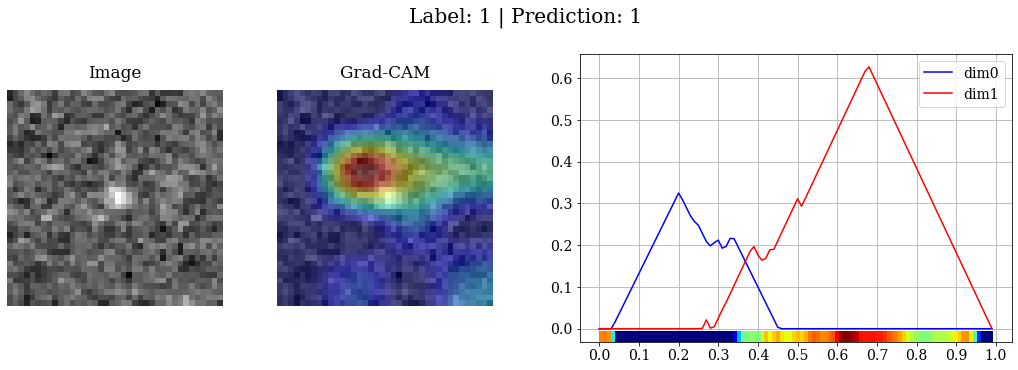

In [17]:
from cnntdanet.gradcam import GradCAMOnCNNTDANet

idx = 14
img = X_img_valid[idx:idx+1]
tda = X_tda_valid[idx:idx+1]
label = np.argmax(y_valid, axis=1)[idx]

gradcam_cnn_tda = GradCAMOnCNNTDANet(cnn_tda, local_layer_name='conv2d_9', global_layer_name='conv1d_8')
gradcam_cnn_tda.to_heatmap([img, tda], true_label=label)
gradcam_cnn_tda.visualize()